<div align="center">
<img src="https://drive.google.com/uc?id=1l_yl0cSu7HTWG9AaUH7D39Wsd1XGUbXn" width="300"><br>
</div>

<h1>EVO: cvičení 2 - Genetický algoritmus</h1>

___

<h2>Řešená úloha - Problém návrhu MOSFET</h2>

<h3>Unipolární tranzistory</h3>

* Obvykle označovány zkratkou FET (Field-Effect-Tranzistor) = proud je řízen elektrickým polem.
* Narozdíl od bipolárních tranzistorů putuje náboj pouze jedním typem materiálu (n nebo p).
* Tři vývody: Source (emitor), Gate (báze) a Drain (kolektor).
* Vysoký vstupní odpor a téměř nulový řídící výkon je dělají vhodné pro řadu využití včetně obvodů s vysokou hustotou integrace.


<h4>MOSFET (Metal Oxide Semiconductor Field Effect Transistor)</h4>

* Unipolrní tranzistor oddělující řídící napětí od kanálu pomocí izolantu oxidu křemičitého.
* Dělení na typ vedoucí bez vnějšího napětí a které naopak vedou s ním. Oba typy se dále dělí na typy s kanálem N a s kanálem P.

MOSFET s nevodivým kanálem N
* Bez účinku vnějšího pole není mezi elektrodami drain a source žádný vodivý kanál.
* Po připojení kladného napětí mezi elektrody gate a source jsou elektrony ze substrátu s dotací P přitahovány ke hradlu gate -> je vytvořen vodivý kanál.
* **Proud na drain je tím vyšší, čím je větší kladné napětí na gate**.

<div align="center">
<img src="https://drive.google.com/uc?id=1qBTp__GX7OAU5iSHzhRGH3IrDhyqJz4d" width="400"><br>
MOSFET tranzistor s nevodivým kanálem N.
</div>

___
<h3>Genetické algoritmy</h3>

* Viz. přednáška z předmětu EVO.

<div align="center">
<img src="https://drive.google.com/uc?id=1pUMFSyq_EjsoiKXWPNB6-KYD951CL-r1" width="500"><br>
</div>

___
<h3>Úkoly</h3>

1. Seznámit se s základy technologie MOSFET.
2. Seznámit se s kódem.
3. Naprogramovat další metodu křížení a selekce.
4. Pomocí genetického algoritmu nalézt vhodné parametry hodnoty délky, šířky a plochy emitoru a kolektoru pro dosažení správné převodní charakteristiky.

V rámci experimentů:
1. Porovnat varianty křížení a selekce.
2. Vyzkoušet upravit fitness funkci.
3. Porvnat nastavení několika parametrů GA.

Stažení souborů nutných k simulaci obvodu

In [3]:
!rm -r libraries target_values
!gdown 1MdYNFDpX5bQUAwpg7UrsIj3G6M-aTtIY
!unzip evo_lab2_files.zip
!rm evo_lab2_files.zip

rm: cannot remove 'libraries': No such file or directory
rm: cannot remove 'target_values': No such file or directory
Downloading...
From: https://drive.google.com/uc?id=1MdYNFDpX5bQUAwpg7UrsIj3G6M-aTtIY
To: /content/evo_lab2_files.zip
100% 5.41k/5.41k [00:00<00:00, 3.81MB/s]
Archive:  evo_lab2_files.zip
   creating: libraries/
   creating: libraries/transistor/
  inflating: libraries/transistor/ptm_65nm_nmos_bulk.mod  
  inflating: libraries/transistor/ptm_65nm_pmos_bulk.mod  
  inflating: target_values           


Instalace potřebných knihoven

In [42]:
!pip install pyspice
!sudo apt install libngspice0-dev
!pyspice-post-installation --check-install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libngspice0-dev is already the newest version (31.3-2).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
OS: linux

Environments:
PATH /opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
LD_LIBRARY_PATH /usr/local/nvidia/lib:/usr/local/nvidia/lib64
PYTHONPATH /env/python
NGSPICE_LIBRARY_PATH undefined
SPICE_LIB_DIR undefined
SPICE_EXEC_DIR undefined
SPICE_ASCIIRAWFILE undefined
SPICE_SCRIPTS undefined
NGSPICE_MEAS_PRECISION undefined
SPICE_NO_DATASEG_CHECK undefined
NGSPICE_INPUT_DIR undefined

Load PySpice module
loaded /usr/local/lib/python3.8/dist-packages/PySpice/__init__.py v

Import použitých knihoven

In [65]:
# Kresleni grafu
import matplotlib.pyplot as plt
import random
import numpy.random as npr

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

# PySpice knihovna pro simulaci obvodu
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

# Nastaveni cesty ke knihovne s komponenty
libraries_path = './libraries'
spice_library = SpiceLibrary(libraries_path)

# Ziskani pseudo-nahodnych cisel
from numpy.random import randint
from numpy.random import rand
from numpy.random import shuffle
import numpy as np

# Nacteni cilovych hodnot
import pickle

Běh simulace tranzistoru

In [6]:
def run_simulation(param):
    circuit = Circuit('NMOS Transistor')
    circuit.include(spice_library['ptm65nm_nmos'])
 
    # DC zdroj
    Vdd = 1.1

    # Vytvoreni potrebnych prvku obvodu
    Vgate = circuit.V('gate', 'gatenode', circuit.gnd, 0@u_V)
    Vdrain = circuit.V('drain', 'vdd', circuit.gnd, u_V(Vdd))

    # Pouziti dodanych parametru MOSFET
    circuit.MOSFET(1,  # Nazev
                   'vdd',  # Drain node (kolektor)
                   'gatenode',  # Gate node (gate/brana)
                   circuit.gnd,  # Source node (emitor)
                   circuit.gnd,  # Bulk/Substrate node
                   model='ptm65nm_nmos',  # Model
                   length=param[0], width=param[1], drain_area=param[2], source_area=param[3])  # Parametry

    # Spusteni simulace
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.dc(Vgate=slice(0, Vdd, .01))  # Postupne navysovani napeti

    return u_mA(-analysis.Vdrain)  # Ziskani krivky napeti na kolektoru

Objektivní/fitness funkce

Každého jedince ohodnotíme pomocí **simulace** v PySpice. Výsledkem simulace je diskrétní řada vzorků hodnoty proudu na kolektoru. Chceme vyhodnotit, jak moc se blíží ideálnímu průběhu.
**Výsledek simulace musíme přepočítat na fitness!**

* Vzdálenost skutečného a ideálního průběhu v každém bodě *x*? 
* Jaká vzdálenost? Kvadraticky? Exponenciálně? (Malé odchylky nám možná ani nevadí, ale velké chceme postihnout.)
* Penelizační funkce? Tzn. odchylky do určité velikosti promíjíme, větší trestáme stejnou měrou. (tj. rozhodování správně/špatně)

*Vyzkoušejte různé varianty objektivní funkce a pozor na případné přetečení hodnot.*

In [69]:
def objective(param, target_values):

    simulation_values = run_simulation(param)  # Ziskani vystupu simulace pro dane parametry
    error = 0.0  # Celkova chyba

    # Vypocet chyby
    for i in range(len(simulation_values)):
        error += abs(target_values[i] - simulation_values[i]) ** 2

    return error

Dekódování chromozomu na jednotlivá čísla

In [8]:
def decode(bounds, n_bits, bitstring):

    decoded = list()  # Vysledny list cisel
    largest = 2**n_bits  # Maximalni mozna hodnota

    for i in range(len(bounds)):  # Pro jednotliva cisla

        # Extrahovani podcasti obsahuji dane cislo
        start, end = i * n_bits, (i * n_bits)+n_bits
        substring = bitstring[start:end]

        # Konverze bitstringu na retezec znaku
        chars = ''.join([str(s) for s in substring])
        
        # Konverze retezce na cislo
        integer = int(chars, 2)
        
        # Skalovani cisla do zadaneho rozsahu
        value = bounds[i][0] + (integer/largest) * (bounds[i][1] - bounds[i][0])
        
        # Ulozeni vysledneho cisla
        decoded.append(value)
    
    return decoded

Selekce

In [9]:
def tournament_selection(pop, scores, k=2):

    # Ziskani nahodneho poradi jedincu
    random_order = list(range(0, len(pop)))
    shuffle(random_order)

    # Vyber prvniho jedince
    best_idx = random_order[0]
 
    # Turnaj se zbyvajicim poctem jedincu a ulozeni jedince s nejmensim score
    for i in range(1, k):

        if scores[random_order[i]] < scores[best_idx]:
            best_idx = random_order[i]

    return pop[best_idx]

*Vyzkoušejte další způsoby selekce probrané na přednáškách. (Náhodný výběr, váženou ruletu, rank order, elitismus...)*

In [57]:
def your_selection(pop, scores, k=2):

    # TODO
    idx = random.randint(0, len(pop) - 1)
    return pop[idx]

def rulette(pop, scores, k=2):
      max = sum([s for s in scores])
      selection_probs = [s/max for s in scores]
      return pop[npr.choice(len(pop), p=selection_probs)]

def elite(pop, scores, k=2):
      max_value = max(scores)
      return pop[scores.index(max_value)]

Křížení

In [12]:
def one_point_crossover(p1, p2, r_cross):

    # Inicializace potomku
    c1, c2 = p1.copy(), p2.copy()

    # Zjisteni, zda se provede krizeni
    if rand() < r_cross:
        
        # Vyber nekoncoveho mista krizeni
        pt = randint(1, len(p1)-2)
        
        # Provedeni krizeni
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]

    return [c1, c2]

*Vyzkoušejte další operátory křížení. (dvoubodové křížení, uniformní křížení...)*

In [38]:
def your_crossover(p1, p2, r_cross):
    # TODO
    c1, c2 = p1.copy(), p2.copy()
    if rand() < r_cross:
      pt1 = randint(1, len(p1) - (len(p1) / 2))
      pt2 = randint(len(p1) - (len(p1) / 2) + 1, len(p1))
      c1 = p1[:pt1] + p2[pt1:pt2] + p1[pt2:]
      c1 = p2[:pt1] + p1[pt1:pt2] + p2[pt2:]
    return [p1, p2]

def uniform_crossover(p1, p2, r_cross):
    c1, c2 = p1.copy(), p2.copy()
    if rand() < r_cross:
      for idx in range(0, len(p1) - 1):
        prob = rand()
        if prob < 0.5:
          c1[idx] = p1[idx]
          c2[idx] = p2[idx]
        else:
          c1[idx] = p2[idx]
          c2[idx] = p1[idx]

    return [c1, c2]

Mutace

In [14]:
def mutation(bitstring, r_mut):
    
    # Pruchod chromozome
    for i in range(len(bitstring)):
        
        # Zjisteni, zda se provede mutace
        if rand() < r_mut:
            
            # Obraceni bitu
            bitstring[i] = 1 - bitstring[i]

Genetický algoritmus

In [71]:
def genetic_algorithm(bounds, n_bits, n_iter, n_pop, r_cross, r_mut, target_values):
	
    # Pocatecni populace nahodnych retezcu 0 a 1
    pop = [randint(0, 2, n_bits*len(bounds)).tolist() for _ in range(n_pop)]

    # Inicializace nejlepsich reseni
    best = 0
    best_eval = objective(decode(bounds, n_bits, pop[0]), target_values)
    new_best = -1
    best_history = []

    # Evoluce
    for gen in range(n_iter):

        # Dekodovani populace
        decoded = [decode(bounds, n_bits, p) for p in pop]

        # Evaluace kandidatnich reseni
        scores = [objective(d, target_values) for d in decoded]

        # Nalezeni nejlepsiho reseni
        for i in range(n_pop):
            if scores[i] < best_eval:
                best = pop[i]
                best_eval = scores[i]
                new_best = i

        # Tisk informace o novem nejlepsim reseni
        if new_best != -1:
            print(">%d, new best f(%s) = %0.30f" % (gen,  decoded[new_best], scores[new_best]))
            best_history.append([gen, scores[new_best]])
            new_best = -1

        # Vyber rodicu v poctu velikosti populace
        # selected = [your_selection(pop, scores) for _ in range(n_pop)]
        selected = [rulette(pop, scores) for _ in range(n_pop)]
        # selected = [elite(pop, scores) for _ in range(n_pop)]

        # Jedinci pristi generace
        children = list()

        for i in range(0, n_pop, 2):
            
            # Zvolni dvou predvybranych prvku
            p1, p2 = selected[i], selected[i+1]

            # Pripadne provedeni krizeni
            for c in your_crossover(p1, p2, r_cross):

                # Mutace jedincu
                mutation(c, r_mut)

                # Ulozeni jedincu do nove generace
                children.append(c)

        # Nahrazeni populace potomky
        pop = children

    return [best, best_eval, best_history]

Hlavní tělo programu

*Vyzkoušejt různá nastavení parametrů. Jak se změní chování programu s různými rozsahy proměnnýh, počtem iteací, velikostí populace...*

>0, new best f([0.00010644237125783693, 0.00010934177112155594, 0.0006041195174626075, 0.00031122486881257497]) = 0.033356046445727073612719237872
>53, new best f([0.00022952675955181475, 3.355569749418646e-06, 0.0006558410727690671, 0.0009915226158622886]) = 0.000569946114028160497576303012
>0, new best f([0.0001901256388930604, 4.346528128264472e-05, 0.0005232525244261604, 0.0005005204883104655]) = 0.019437097310568522690044090950
>56, new best f([7.415991184732411e-05, 8.409128015434835e-05, 6.999768384280614e-05, 0.0009915900603874586]) = 0.009272622445087301545907365607
>58, new best f([7.43019876608858e-05, 6.932235508717131e-05, 5.795075900037773e-06, 0.000991648230565805]) = 0.006666448070090874242210610134
Done!


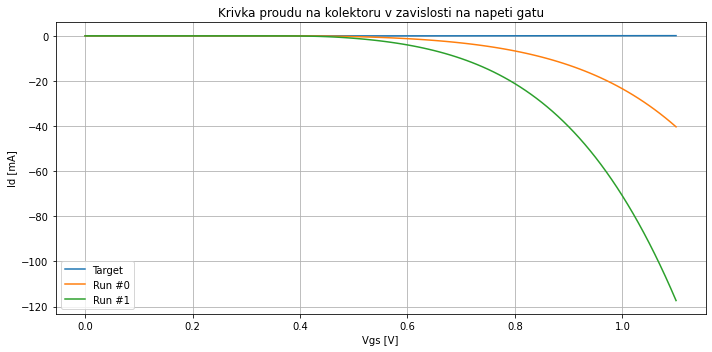

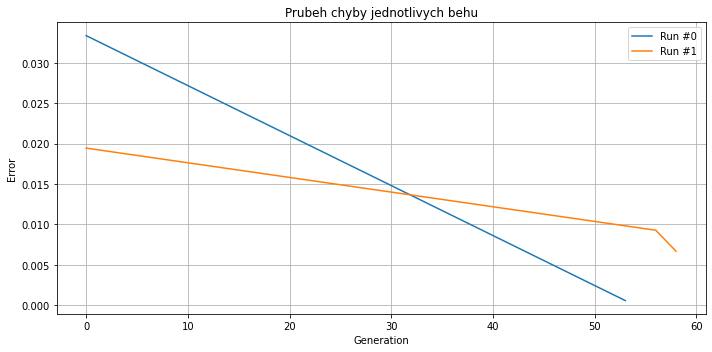

In [72]:
# Pocet behu programu
n_runs = 2

# Mozny rozsah jednotlivych hodnot
bounds = [[0.1e-6, 0.1e-2], [0.1e-6, 0.1e-2], [0.1e-6, 0.1e-2], [0.1e-6, 0.1e-2]]

# Pocet iteraci
n_iter = 100

# Bitu pro kazdou promennou
n_bits = 32

# Velikost populace
n_pop = 10

# Pravdepodobnost krizeni
r_cross = 0.9

# Pravdepodobnost mutace
r_mut = 1.0 / (float(n_bits) * len(bounds)) 

# Nacteni cilovych hodnot proudu na kolektoru
file = open('target_values', 'rb')
target_values = pickle.load(file)

# Provedeni genetickeho algoritmu
results = [genetic_algorithm(bounds, n_bits, n_iter, n_pop, r_cross, r_mut, target_values) for _ in range(n_runs)]

print('Done!')

# Plot vyslednych vlastnostni navrzenych reseni
figure, ax = plt.subplots(figsize=(10, 5))
ax.plot([i/100 for i in range(0, 111)], target_values, label='Target')
for i in range(len(results)):
    ax.plot([i/100 for i in range(0, 111)], run_simulation(decode(bounds, n_bits, results[i][0])), label=f"Run #{i}")
ax.legend()
ax.grid()
ax.set_xlabel('Vgs [V]')
ax.set_ylabel('Id [mA]')
plt.title('Krivka proudu na kolektoru v zavislosti na napeti gatu')
plt.tight_layout()
plt.show()

print('')

# Plot prubehu nejlepsich reseni jednotlivych behu
figure, ax = plt.subplots(figsize=(10, 5))
for i in range(len(results)):
    ax.plot(*zip(*results[i][2]), label=f"Run #{i}")
ax.legend()
ax.grid()
ax.set_xlabel('Generation')
ax.set_ylabel('Error')
plt.title('Prubeh chyby jednotlivych behu')
plt.tight_layout()
plt.show()

Autor:<br>
Ing. Martin Hurta

Použité zdroje:<br>
https://machinelearningmastery.com/<br>
https://pyspice.fabrice-salvaire.fr/<br>
FROHN, M. Elektronika: polovodičové součástky a základní zapojení. Praha: BEN - technická literatura, 2006, 479 s. : il. ISBN 80-7300-123-3.